In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype

In [2]:
#Format days of the week to not appear alphabetically on visuals
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
cat_type = CategoricalDtype(categories=cats, ordered=True)

In [12]:
# Source: http://web.mta.info/developers/turnstile.html
df1 = pd.concat(map(pd.read_csv, (['http://web.mta.info/developers/data/nyct/turnstile/turnstile_190504.txt',
                    'http://web.mta.info/developers/data/nyct/turnstile/turnstile_190511.txt',
                    'http://web.mta.info/developers/data/nyct/turnstile/turnstile_190518.txt',
                    'http://web.mta.info/developers/data/nyct/turnstile/turnstile_190525.txt',
                    'http://web.mta.info/developers/data/nyct/turnstile/turnstile_190601.txt'])),ignore_index=True)

In [13]:
#Convert Date and Time into a more useable DateTime format.
def df_DateTime(df):
    df['DateTime'] = pd.to_datetime(df.DATE+' '+df.TIME)
    return df

#Record what day of the week each entry is from
def df_day_of_week(df):
    df['Day']=df.DateTime.dt.day_name()
    return df

#SCP represents a specific turnstile.
#C/A represents a control area. This is a bank of turnstiles.  
#Unit represents a remote unit. Usually a whole station, or an area in a complex station.
#We can combine all three to create a unique ID for any turnstile
def df_Unit_ID(df):
    df['Unit_ID'] = df.SCP+' '+df['C/A']+' '+df.UNIT
    return df

#Rename Exits column to remove extra spaces
def rename_columns(df):
    df.rename(columns={'EXITS                                                               ':'EXITS'},inplace=True)
    return df

#Remove irregularities in reporting
def clean_desc(df):
    df = df[df.DESC == 'REGULAR']
    return df

#Calculate the entries/exits in a four hour period by finding the difference between rows
def df_four_hour(df):
    df['Four Hour Entries'] = df.groupby('Unit_ID').ENTRIES.diff()
    df['Four Hour Exits'] = df.groupby('Unit_ID').EXITS.diff()
    return df

#Replace NaN, negative values, and impossibly large values by the average of the turnstile
def df_clean_four_hour(df):
    df['Four Hour Entries'].fillna(-1, inplace=True)
    df['Four Hour Exits'].fillna(-1, inplace=True)
    df['Four Hour Entries'] = df.groupby(['TIME','C/A'])['Four Hour Entries'].transform(
        lambda x: np.where((x<0)|(x>20000),x.mask((x<0)|(x>20000)).mean(),x))
    df['Four Hour Exits'] = df.groupby(['TIME','C/A'])['Four Hour Exits'].transform(
        lambda x: np.where((x<0)|(x>20000),x.mask((x<0)|(x>20000)).mean(),x))
    return df

#Create a column for the total amount of traffic through a turnstile
def df_total_flow(df):
    df['Total Flow'] = df['Four Hour Entries']+df['Four Hour Exits']
    return df

In [14]:
df1 = df_DateTime(df1)
df1 = df_day_of_week(df1)
df1 = df_Unit_ID(df1)
df1 = rename_columns(df1)
df1 = df_four_hour(df1)
df1 = df_clean_four_hour(df1)
df1 = clean_desc(df1)
df1 = df_total_flow(df1)
df1.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DateTime,Day,Unit_ID,Four Hour Entries,Four Hour Exits,Total Flow
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,00:00:00,REGULAR,7035249,2384833,2019-04-27 00:00:00,Saturday,02-00-00 A002 R051,150.529703,48.537129,199.066832
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,04:00:00,REGULAR,7035269,2384840,2019-04-27 04:00:00,Saturday,02-00-00 A002 R051,20.000000,7.000000,27.000000
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,08:00:00,REGULAR,7035292,2384875,2019-04-27 08:00:00,Saturday,02-00-00 A002 R051,23.000000,35.000000,58.000000
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,12:00:00,REGULAR,7035392,2384951,2019-04-27 12:00:00,Saturday,02-00-00 A002 R051,100.000000,76.000000,176.000000
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,16:00:00,REGULAR,7035651,2385020,2019-04-27 16:00:00,Saturday,02-00-00 A002 R051,259.000000,69.000000,328.000000


In [25]:
#Find daily sum for each STATION for each day of the week
df1_daily = df1.groupby(['STATION','DATE'])['Total Flow'].sum()
df1_daily.head(20)

STATION  DATE      
1 AV     04/27/2019    15989.676471
         04/28/2019    12444.000000
         04/29/2019    36454.000000
         04/30/2019    39009.000000
         05/01/2019    40345.000000
         05/02/2019    40741.000000
         05/03/2019    42397.000000
         05/04/2019    17728.000000
         05/05/2019    13728.000000
         05/06/2019    36691.000000
         05/07/2019    39146.000000
         05/08/2019    40615.000000
         05/09/2019    41254.000000
         05/10/2019    41024.000000
         05/11/2019    18131.000000
         05/12/2019    11859.000000
         05/13/2019    36908.000000
         05/14/2019    40150.000000
         05/15/2019    41294.000000
         05/16/2019    40763.000000
Name: Total Flow, dtype: float64

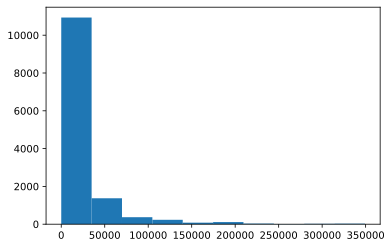

In [61]:
plt.hist(df1_daily)
plt.show()

In [62]:
ridership = df1.groupby(['STATION'])['Total Flow'].sum()
top_10 = ridership.sort_values(ascending=False).reset_index().round(0).head(10)
top_10

,STATION,Total Flow
0,34 ST-PENN STA,9872320.0
1,GRD CNTRL-42 ST,8283119.0
2,34 ST-HERALD SQ,7184261.0
3,14 ST-UNION SQ,6136192.0
4,TIMES SQ-42 ST,6036652.0
5,23 ST,5951988.0
6,42 ST-PORT AUTH,5694885.0
7,FULTON ST,5310743.0
8,86 ST,5119460.0
9,125 ST,4472492.0


<function matplotlib.pyplot.show(*args, **kw)>

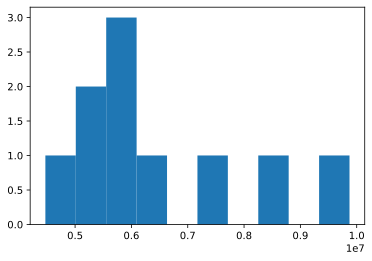

In [51]:
plt.hist(top_10)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

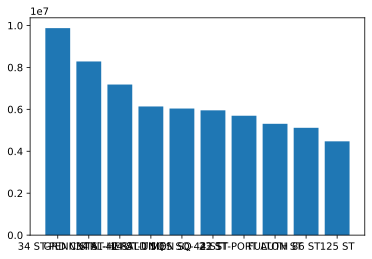

<Figure size 72000x14400 with 0 Axes>

In [58]:
plt.bar(top_10['STATION'],top_10['Total Flow'])
plt.figure(figsize = [1000,200])
plt.show